# DELCODE WMH Segmentation Pipeline

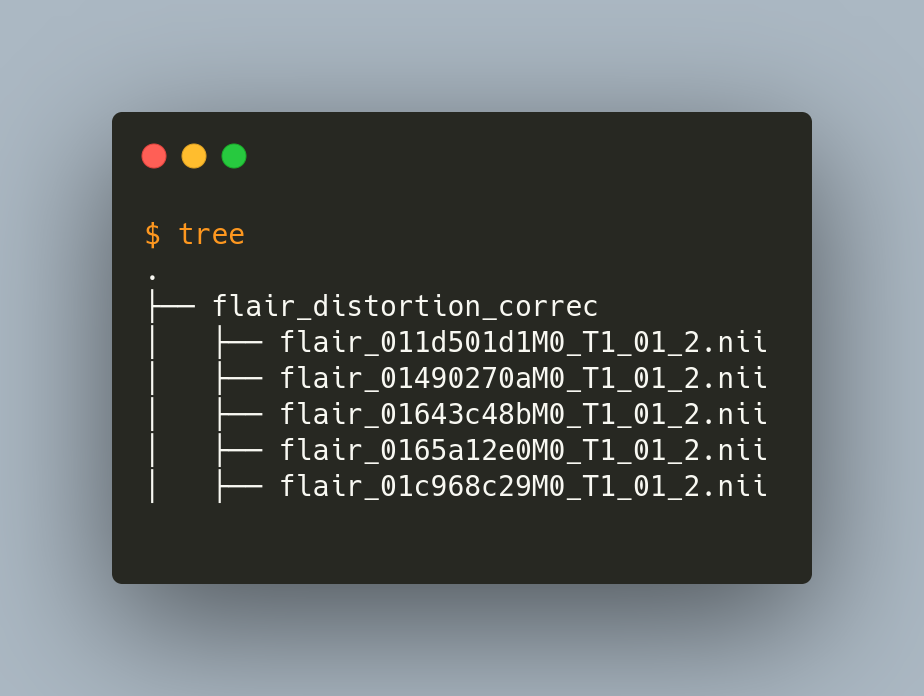

In [5]:
from IPython.display import Image
Image('./imgs/tree.png') # <- put away MPRage

# Integrating in another workflow

We want to segment the WMHs in our dataset while integrating our sysu_media implementation in a bigger preprocessing workflow.

Every FLAIR should be:
1. Brain Extracted (FSL bet)
2. Denoised with spatial-adaptive Non-Local Means (SANLM) filter (CAT12)

the result can be given as an input to sysu_media

In [6]:
from nipype.pipeline.engine import Workflow, Node

In [7]:
from wmhpypes.interfaces import cat12
from wmhpypes.interfaces import misc
from nipype.interfaces import fsl

In [8]:
delcode = Workflow(name='delcode', base_dir='./delcode')

bet = Node(interface=fsl.BET(reduce_bias=True,
                             frac=.2,
                             output_type='NIFTI'), name='bet')
denoising = Node(interface=cat12.CAT12SANLMDenoising(), name='denoising')

delcode.connect(bet, 'out_file', denoising, 'in_files')

stty: 'standard input': Inappropriate ioctl for device


210914-16:24:31,991 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/delcode.png (graph2use=colored, simple_form=True).


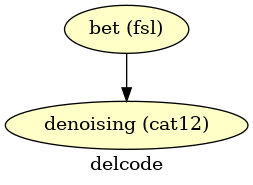

In [9]:
delcode.write_graph(graph2use='colored', dotfilename='./imgs/delcode.dot')
Image('./imgs/delcode.png')

## 1. Install WMHPypes

In [10]:
%%bash
#git clone https://github.com/0rC0/WMHpypes.git
#cd WMHpypes
#conda create -n wmhpypes pip --yes
#conda activate wmhpypes
#pip install --quiet -r requirements.txt
#pip install . --quiet
# cd ..

2021-09-14 16:24:32.274078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-14 16:24:32.274128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


210914-16:24:33,930 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/nn.png (graph2use=colored, simple_form=True).


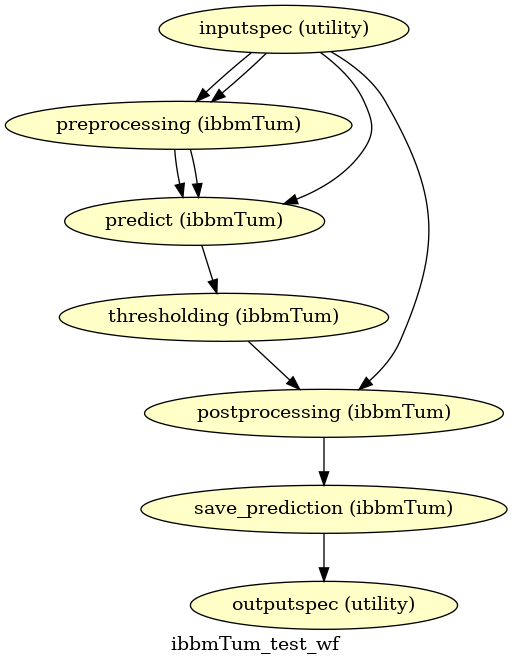

In [11]:
from wmhpypes.workflows import ibbmTum_wf
test_wf = ibbmTum_wf.get_test_wf(row_st=192,
                                     cols_st=192,
                                     thres_mask=10)
test_wf.write_graph(graph2use='colored', dotfilename='./imgs/nn.dot')
Image('./imgs/nn.png')

The inputspec accept as inputs:

1. flair
2. weights

The outputspec returns as an output:

1. wmh_mask

In [12]:
from nipype import DataGrabber, DataSink, IdentityInterface

In [13]:
#Subject IDs
import os
sub_ids = [i.strip('flair_').strip('.nii.gz') for i in os.listdir('./test_dataset/flair')]
data_source = Node(interface=IdentityInterface(fields = ['weights', 'sub-id']), name='data_source')
data_source.iterables = ('sub-id', sub_ids)
data_source.inputs.weights = [os.path.join(os.getcwd(), './WMHpypes/models', i) for i in os.listdir('./WMHpypes/models')]

FileNotFoundError: [Errno 2] No such file or directory: './test_dataset/flair'

In [ ]:
data_grabber = Node(interface=DataGrabber(infields=['sub-id'],
                                          outfields=['flair']), name='data_grabber')
data_grabber.inputs.base_directory = os.path.abspath('./test_dataset')
data_grabber.inputs.template = 'flair/flair_%s.nii.gz'
data_grabber.inputs.template_args = {'flair' : [['sub-id']]}
data_grabber.inputs.sort_filelist = False

In [ ]:
delcode.connect(data_source, 'sub-id', data_grabber, 'sub-id')
delcode.connect(data_grabber, 'flair', bet, 'in_file')
delcode.connect(denoising, 'out_file', test_wf, 'inputspec.flair')
delcode.connect(data_source, 'weights', test_wf, 'inputspec.weights')

In [ ]:
from IPython.display import Image
delcode.write_graph(graph2use='colored', dotfilename='./imgs/delcode.dot')
Image('./imgs/delcode.png')

In [ ]:
save_nii = Node(interface=misc.SaveNIfTI(), name='save_nii')
sink = Node(interface=DataSink(), name = 'sink')
sink.inputs.base_directory = os.path.abspath('./out')

In [ ]:
delcode.connect(test_wf, 'outputspec.wmh_mask', save_nii, 'in_array') 
delcode.connect(data_grabber, 'flair', save_nii, 'in_header')
delcode.connect(data_grabber, 'flair', save_nii, 'in_matrix')                
delcode.connect(save_nii, 'out_file', sink, '@wmh_mask')

In [ ]:
from IPython.display import Image
delcode.write_graph(graph2use='colored', dotfilename='./imgs/delcode.dot')
Image('./imgs/delcode.png')

In [ ]:
# Run it

In [ ]:
# we are now ready to run the pipeline

In [18]:
plugin_args = {'n_procs': 5}
delcode.run(plugin='MultiProc', plugin_args=plugin_args)

210913-23:37:20,656 nipype.workflow INFO:
	 Workflow delcode settings: ['check', 'execution', 'logging', 'monitoring']
210913-23:37:20,668 nipype.workflow INFO:
	 Running in parallel.
210913-23:37:20,672 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.60/13.60, Free processors: 5/5.
210913-23:37:20,784 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/home/dellorcoa/Documents/DZNE/WMHpypes/workshop/delcode/delcode/_sub-id_01dc83c85M0_T1_01_1/data_grabber".
210913-23:37:20,790 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210913-23:37:20,796 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210913-23:37:22,673 nipype.workflow INFO:
	 [Job 0] Completed (delcode.data_grabber).
210913-23:37:22,677 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.60/13.60, Free processors: 5/5.
210913-23:37:22,907 nipype.workflow INFO:
	 [Job 1

2021-09-13 23:37:53.505733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-13 23:37:53.505793: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-13 23:37:53.505842: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dd-ll-wirth01): /proc/driver/nvidia/version does not exist
2021-09-13 23:37:53.506424: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dellorcoa/anaconda3/envs/wmhpypes/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: U

256/256 [==============================] - ETA: 33 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20

sizeof_hdr should be 540; set sizeof_hdr to 540


210913-23:39:59,909 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210913-23:40:00,815 nipype.workflow INFO:
	 [Job 8] Completed (delcode.save_nii).
210913-23:40:00,819 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.60/13.60, Free processors: 5/5.
210913-23:40:01,33 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/home/dellorcoa/Documents/DZNE/WMHpypes/workshop/delcode/delcode/_sub-id_01dc83c85M0_T1_01_1/sink".
210913-23:40:01,41 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210913-23:40:01,49 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210913-23:40:02,817 nipype.workflow INFO:
	 [Job 9] Completed (delcode.sink).
210913-23:40:02,821 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.60/13.60, Free processors: 5/5.


In [ ]:
!fsleyes /home/dellorcoa/Documents/DZNE/WMHpypes/workshop/test_dataset/flair/flair_01dc83c85M0_T1_01_1.nii.gz \
/home/dellorcoa/Documents/DZNE/WMHpypes/workshop/delcode/delcode/_sub-id_01dc83c85M0_T1_01_1/bet/flair_01dc83c85M0_T1_01_1_brain.nii \
/home/dellorcoa/Documents/DZNE/WMHpypes/workshop/delcode/delcode/_sub-id_01dc83c85M0_T1_01_1/denoising/sanlm_flair_01dc83c85M0_T1_01_1_brain.nii \
/home/dellorcoa/Documents/DZNE/WMHpypes/workshop/out/_sub-id_01dc83c85M0_T1_01_1/prediction.nii.gz